## Import Library

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

## Read Data

In [65]:
df = pd.read_csv('/content/drive/MyDrive/Datacamp/boat_data.csv')
df.head()

,Price,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days
0,CHF 3337,Motor Yacht,Rigiflex power boats,new boat from stock,2017,4.00,1.90,NaN,Switzerland Â» Lake Geneva Â» VÃ©senaz,226
1,EUR 3490,Center console boat,Terhi power boats,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany Â» BÃ¶nningstedt,75
2,CHF 3770,Sport Boat,Marine power boats,new boat from stock,0,3.69,1.42,Aluminium,Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH,124
3,DKK 25900,Sport Boat,Pioner power boats,new boat from stock,2020,3.00,1.00,NaN,Denmark Â» Svendborg,64
4,EUR 3399,Fishing Boat,Linder power boats,new boat from stock,2019,3.55,1.46,Aluminium,Germany Â» Bayern Â» MÃ¼nchen,58


In [66]:
df.isna().sum()

Price                             0
Boat Type                         0
Manufacturer                   1338
Type                              6
Year Built                        0
Length                            9
Width                            56
Material                       1749
Location                         36
Number of views last 7 days       0
dtype: int64

Some columns, such as Manufacturer, Type, Length, Width, Material and Location, have missing value and need to be cleaned first

## Cleaning Data

### Length

Since the length distribution is skewed, replace the missing value with median

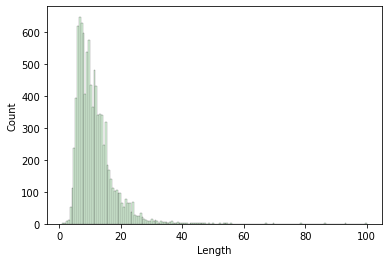

In [67]:
# Checking the distribution
sns.histplot(df.Length)

# Replace missing value 'Length' with median
df['Length'] = df['Length'].fillna(df['Length'].median())

### Width

Since the width distribution is skewed, replace the missing value with median

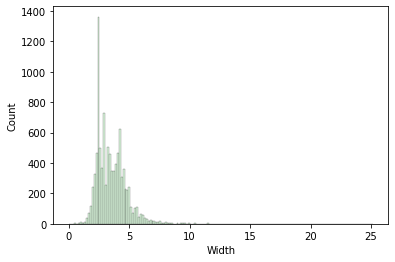

In [68]:
# Checking the distribution
sns.histplot(df.Width)

# Replace missing value 'Width' with median
df['Width'] = df['Width'].fillna(df['Width'].median())

### Price

The price column has different currency. To equalize the currency, split the column into currency and nominal first and then convert the nominal into euro since is the most currency

In [69]:
# Split the column 'Price' into currency and nominal
df[['currency', 'nominal']] = df['Price'].str.split(' ', 1, expand=True)

# Change 'Nominal' data type
df['nominal'] = df['nominal'].astype(float)

# Checking the most currency 
df['currency'].value_counts()

# Currency converter function 
def convert(currency, nominal):
  if currency == 'CHF': return nominal * 0.99
  elif currency == 'DKK': return nominal * 0.13
  elif currency == 'Â£': return nominal * 1.17
  else: return nominal

# Convert
df['nominal'] = df.apply(lambda x: convert(x['currency'], x['nominal']), axis = 1)

# Rename 'nominal' column
df.rename(columns = {'nominal':'Price (EUR)'}, inplace = True)

### Location

Take only the first string of the location. To fill the missing value, i replace the value with some country. In choosing the country replacement, i observed the data with the missing value first and choose it based on the value counts of currency, boat type and location columns

In [70]:
# Only take country for 'Location' column
df['Location'] = df['Location'].str.split('Â»').str[0]

# Checking 
df[['currency', 'Boat Type', 'Location']].value_counts()

# Function
def impute_location(currency, boat_type):
  if currency == 'Â£':
    return 'United Kingdom'
  else:
    if boat_type == 'Motor Yacht' or boat_type == 'Flybridge' or boat_type == 'Mega Yacht':
      return 'Italy'
    elif boat_type == 'Motorsailer':
      return 'Turkey'
    elif boat_type == 'Passenger boat':
      return 'Netherlands '

# Impute
df['Location'] = df.apply(lambda x: impute_location(x['currency'], x['Boat Type']) if pd.isnull(x['Location']) else x['Location'], axis = 1)


### Type
Split type column into condition and engine and and fix some misplaced values between condition and engine. Fill the remain missing value with 'Unknown'

In [71]:
# Split the column 'Type' into Condition and Engine
df[['Condition', 'Engine']] = df['Type'].str.split(',', 1, expand=True)

# fix swapped column
df['Engine'] = df.apply(lambda x: x['Condition'] if x['Condition'] == 'Unleaded' or x['Condition'] == 'Diesel' or x['Condition'] == 'Electric' else x['Engine'], axis = 1)
df['Condition'] = df.apply(lambda x: None if x['Condition'] == 'Unleaded' or x['Condition'] == 'Diesel' or x['Condition'] == 'Electric' else x['Condition'], axis = 1)

# fill missing value with unknown
df['Engine'] = df['Engine'].fillna('Unknown')
df['Condition'] = df['Condition'].fillna('Unknown')

### Boat Type
Split boat type column into 3 type. Fill the remain missing value with 'Unknown'

In [72]:
# Split the boat type into 3 type
df[['Boat Type 1', 'Boat Type 2', 'Boat Type 3']] = df['Boat Type'].str.split(',', 2, expand=True)

# Fill the missing value
df['Boat Type 2'] = df['Boat Type 2'].fillna('Unknown')
df['Boat Type 3'] = df['Boat Type 3'].fillna('Unknown')

### Year Built
Drop the rows where its year built is zero

In [73]:
df = df[df['Year Built'] != 0]

### Remaining Column
Drop the rows with the missing value

In [74]:
df = df.dropna()

### Categorical Data
To make it easier, change some columns such as views page, price and year built, into categorical data. I use Quantile-based discretization function to devide it into 5 equal part

In [75]:
# Views
df['Views Level'] = pd.qcut(df['Number of views last 7 days'], q=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=['Very Low (< 66 Views)', 'Low (66 - 96 Views)', 'Moderate (97 - 136 Views)', 'High (137 - 218 Views)', 'Very High (> 218 Views)'])

# Price 
df['Price Level'] = pd.qcut(df['Price (EUR)'], q=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=['Very Cheap (< 37.991 €)', 'Cheap (37.991 - 69.650 €)', 'Moderate (69.651 - 139.000 €)', 'Expensive (139.001 - 299.000 €)', 'Very Expensive (> 299.000 €)'])

# Year Built
df['Year Built Level'] = pd.qcut(df['Year Built'], q=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=['Very Old (< 1999)', 'Old (1999 - 2006)', 'Moderate (2007 - 2013)', 'New (2014 - 2019)', 'Very New (> 2019)'])

### Finalization
Drop some unnecessary columns, sort value based on number views and reset the index

In [76]:
# Take the necessary columns
df = df[['Price (EUR)', 'Price Level', 'Boat Type 1', 'Manufacturer', 'Year Built','Year Built Level', 'Length', 'Width', 'Material', 'Location', 'Condition', 'Engine', 'Number of views last 7 days', 'Views Level']]

# Sort Value
df = df.sort_values('Number of views last 7 days', ascending=False)

# Reset Index
df.reset_index(drop=True, inplace=True)

## First Question: Is it the most expensive boats that get the most views?

To answer this question, i look into the table which inform the views based on top 5 price and also the table which inform the price based on the top 5 views.

In [77]:
df[['Price (EUR)', 'Number of views last 7 days']].sort_values('Price (EUR)', ascending=False).head(5)

,Price (EUR),Number of views last 7 days
359,23500000.0,419
669,11900000.0,317
1778,11694150.0,178
1528,11000000.0,197
1260,10800000.0,225


In [78]:
df[['Number of views last 7 days', 'Price (EUR)']].sort_values('Number of views last 7 days', ascending=False).head(5)

,Number of views last 7 days,Price (EUR)
0,3263,14751.0
1,2432,34650.0
2,2261,124641.0
3,2154,949000.0
4,2026,19701.0


Based on those two tables, we can easily tell that the price does’t really affect the views. For example take a look at the first table, the views for the highest price is only 419 views. It’s considered not really high since the highest views page is 3263, and the price for it is only 14751 €

For more details, take a look at this scatterplot

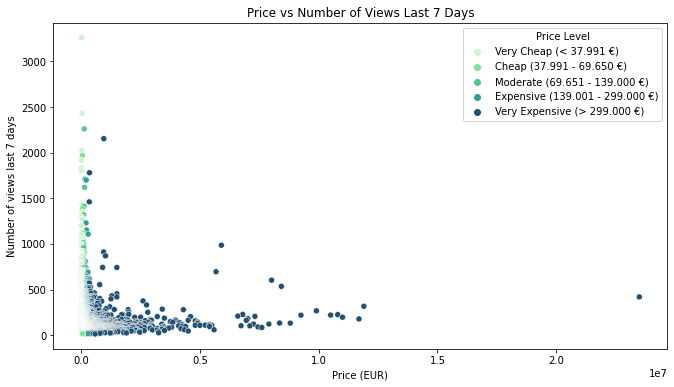

The correlation: -0.045774494545330176


In [79]:
# Scatter Plot
sns.set_palette(['#CFF4D2', '#7BE495', '#56C596', '#329D9C', '#205072'])
plt.figure(figsize=(11,6))
sns.scatterplot(x='Price (EUR)', y='Number of views last 7 days', data=df, hue='Price Level')
plt.title('Price vs Number of Views Last 7 Days')
plt.show()

# Correlation
corr = df['Price (EUR)'].corr(df['Number of views last 7 days'])
print('The correlation:', corr)

Based on what it looks like, we can tell that price and number views dont have a linear relationship, and the correlation is very bad, around -0.04.  And look at the dot for the highest views. Based on the price level, the price is considered really cheap. 

So the conclusion is the most expensive boats doesn’t always get the most views

##  The second question: Are there common features among the most viewed boats?
To answer this question, i’ve vizualized some feature such as price level, year built level, boat type, material, condition, engine, manufacturer and location in the x axis and the value count of its feature in the y axis and for the color encoding i use views page level columns. For the x axis, i ordered the category based on most value counts. And to make it easier lets focus to the bar with the navy color which is the very high views category in views level. 

In [80]:
# Plot Function
# x: x axis
# order 0: ordered
# order 1: not ordered
# title: tittle of the plot
# label: length to wrap the label
# hue: color encoding

def barplot(x, order, title, label, hue):
  sns.set_palette(['#CFF4D2', '#7BE495', '#56C596', '#329D9C', '#205072'])
  plt.figure(figsize=(20,10))
  if order == 1:
    g = sns.countplot(x=x, data=df, hue=hue, order=df[x].value_counts().iloc[:10].index)
    labels = df[x].value_counts().iloc[:10].index.tolist()
    labels = [ '\n'.join(wrap(l, label)) for l in labels]
    g.set_xticklabels(labels)
  else:
    g = sns.countplot(x=x, data=df, hue=hue)
  g.set_title(title, size=20)
  g.set_xlabel(x, size=15)
  g.set_ylabel('Count', size=15)
  plt.legend(loc='upper right')
  plt.show()

### Price level

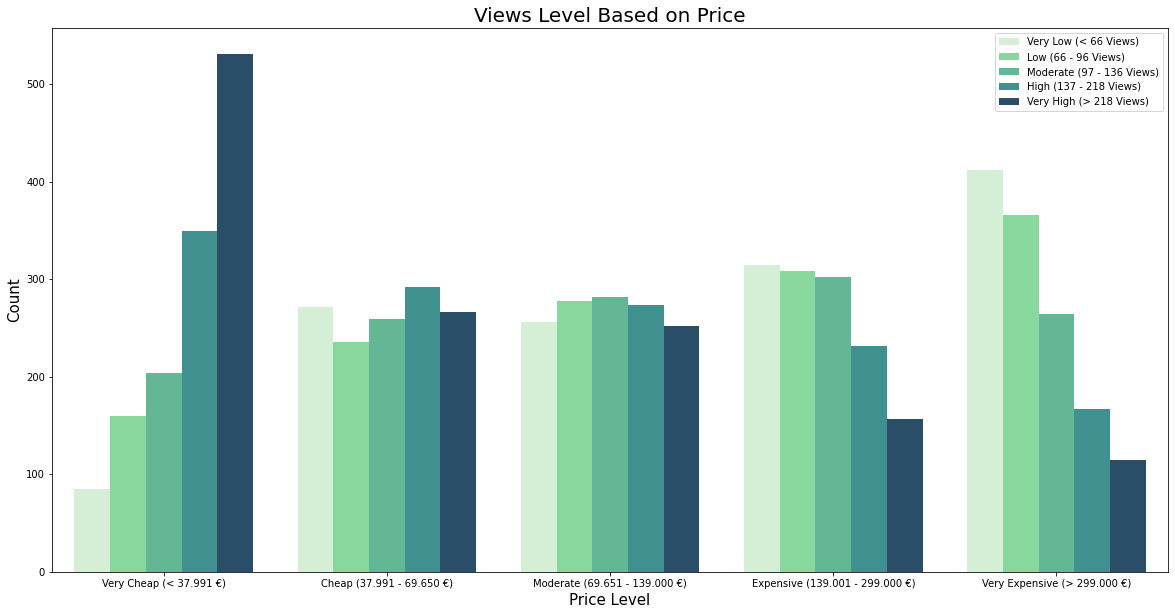

In [81]:
barplot('Price Level', 0, 'Views Level Based on Price', 100, 'Views Level')

For price level, the very cheap category has the the highest navy bar which means the are around 500 boat where the price of the boat is less than 37.991€ and the views page for each boat is more than 218 views. We also can say that, the more expensive the boat is the less views the page has. It also answer the first question that The most expensive boats doesn’t always get the most views. It’s like people tend to choose a cheap boat.

### Year Built Level
For the year built level, the very old category has the the highest navy bar which means the are almost 500 boat where the boat is built in less than 1999 and the views page for each boat is more than 218 views. Seems like most of the old boat has the cheaper price so that’s why people tend to choose the old boat.


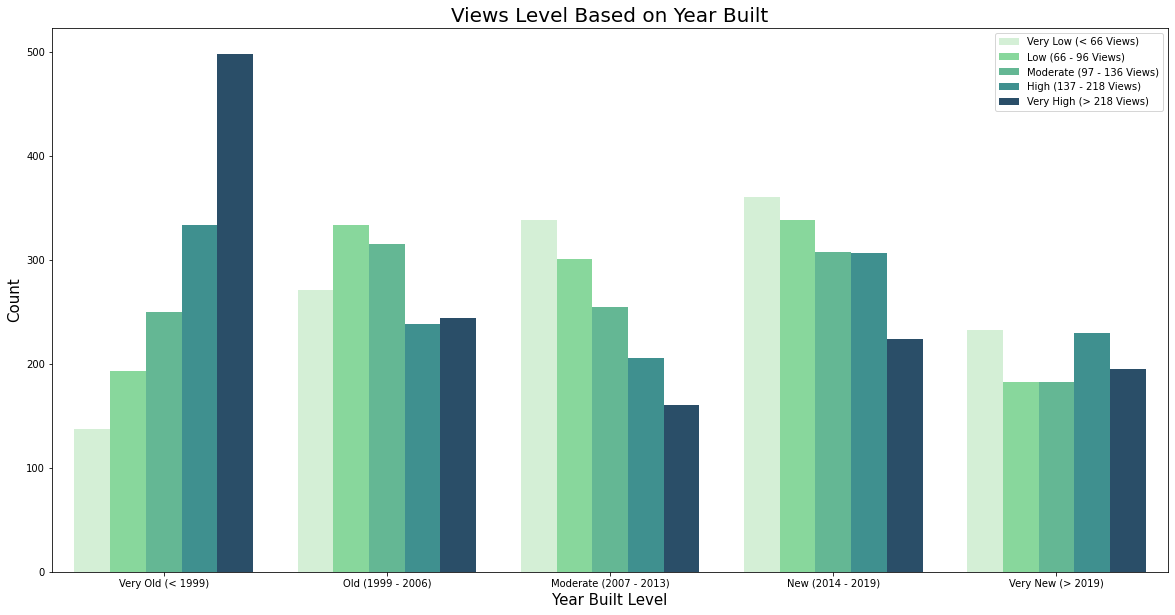

In [82]:
barplot('Year Built Level', 0, 'Views Level Based on Year Built', 100, 'Views Level')

Here’s the prove that the most of the old boat has the cheaper price. You can see that the very expensive bar (the navy bar) in the very old boat category is the lowest 

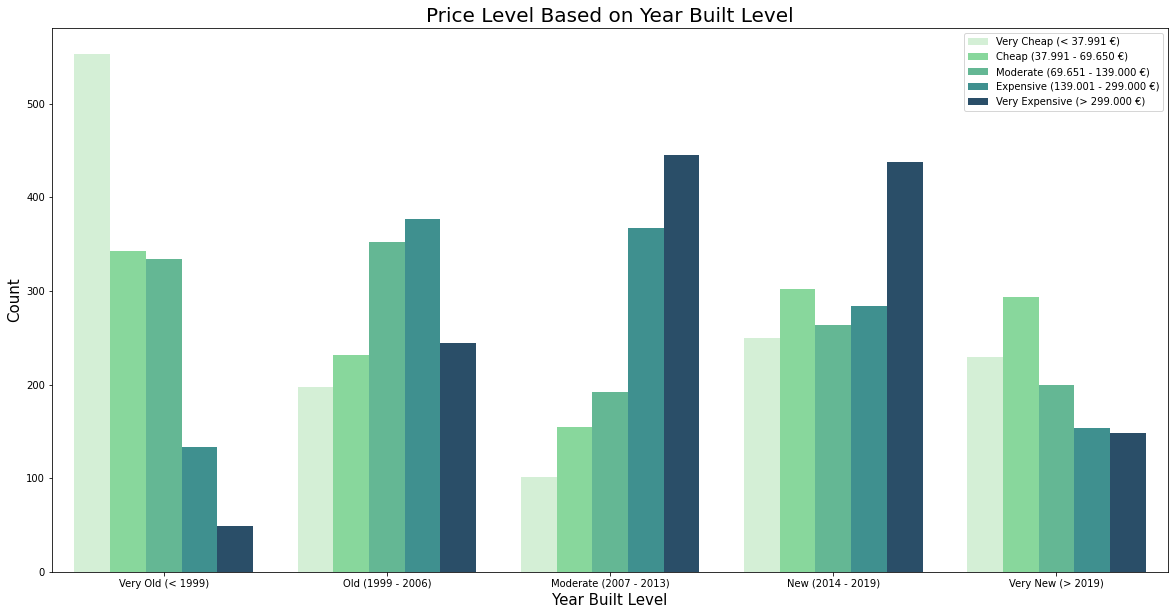

In [83]:
barplot('Year Built Level', 0, 'Price Level Based on Year Built Level', 100, 'Price Level')

### Boat Type

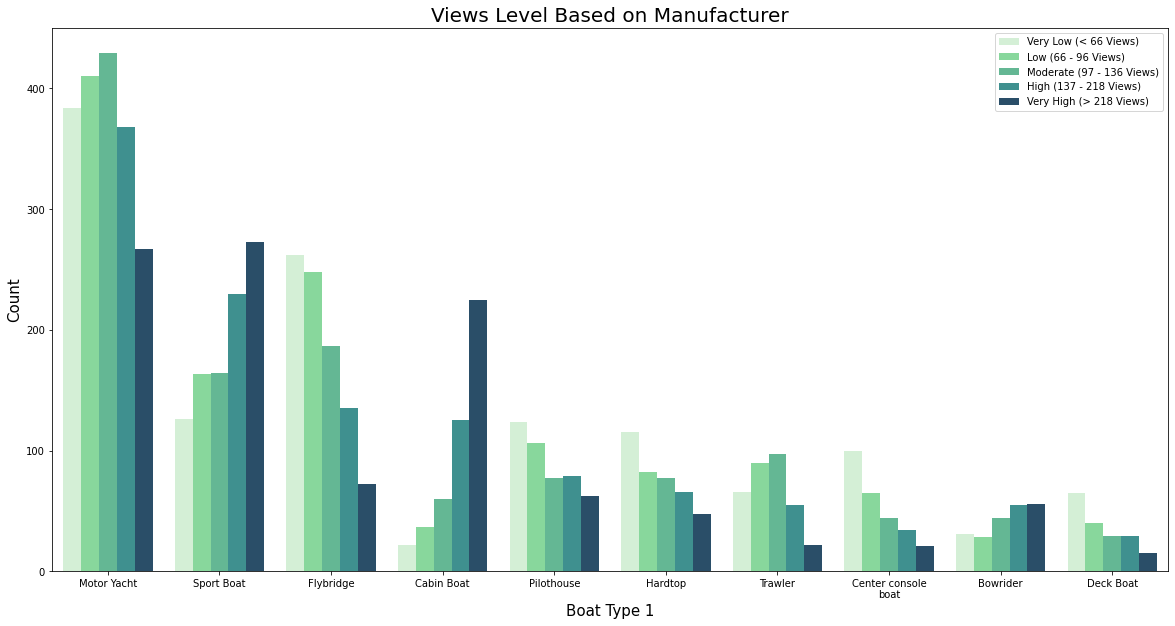

In [84]:
barplot('Boat Type 1', 1, 'Views Level Based on Manufacturer', 15, 'Views Level')

For the boat type feature, the are 3 type where the navy bar almost has the same height, those are motor yacht, sport boat, and cabin boat. Seems like people tend to choose among these three category because it’s for recreation

### Material

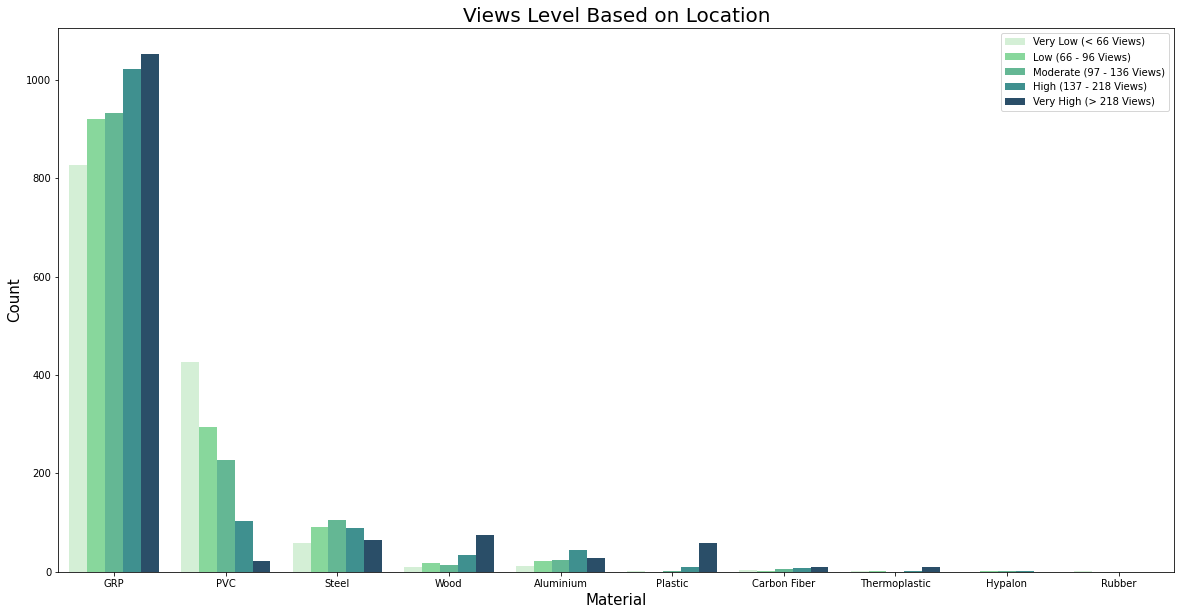

In [85]:
barplot('Material', 1, 'Views Level Based on Location', 100, 'Views Level')

For the material feature, we clearly can say that RGP is so popular as the material to build the boat

### Condition

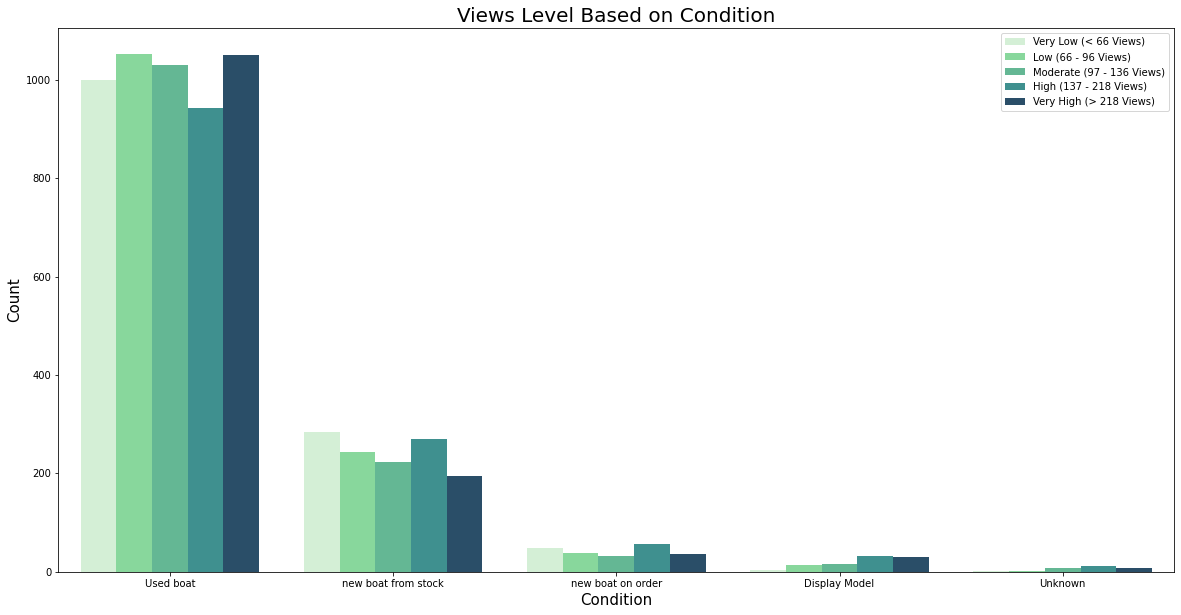

In [86]:
barplot('Condition', 1, 'Views Level Based on Condition', 100, 'Views Level')

Same as material, for the condition feature, used boat is dominating the views page level.

### Engine

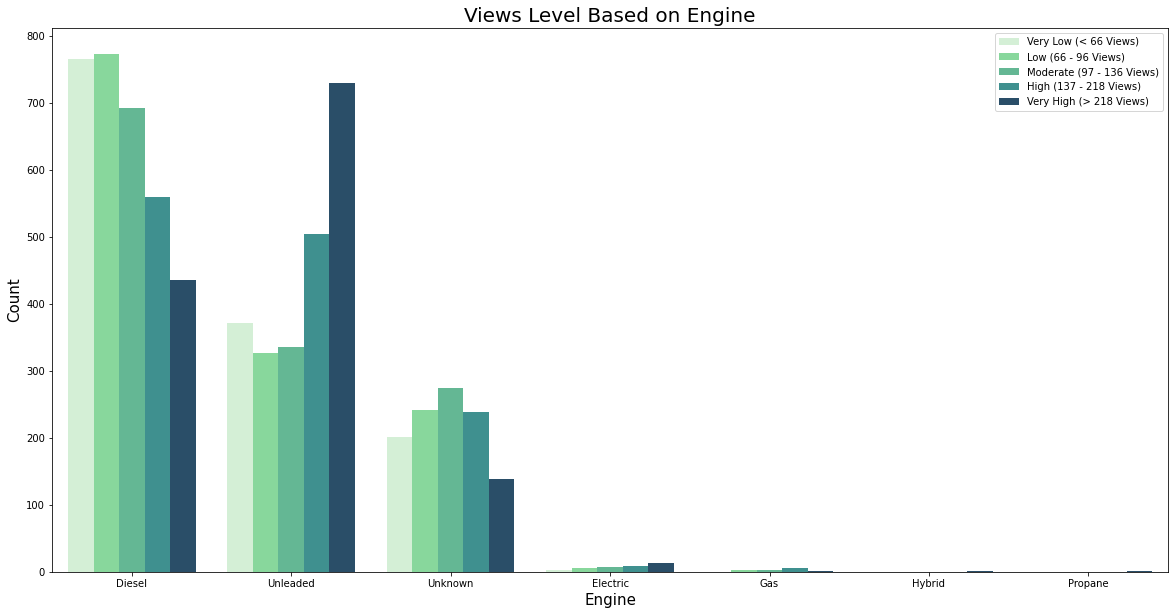

In [87]:
barplot('Engine', 1, 'Views Level Based on Engine', 100, 'Views Level')

For the engine feature, even though diesel dominate the views in general but unleaded has the highest very high views bar

### Manufacturer

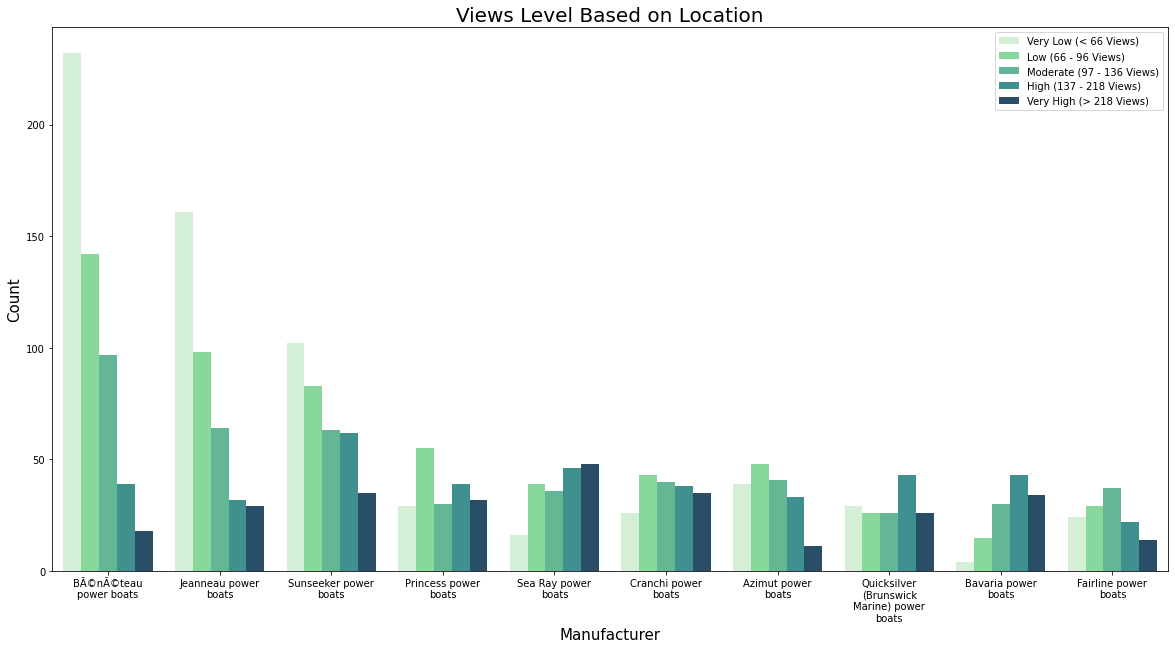

In [88]:
barplot('Manufacturer', 1, 'Views Level Based on Location', 15, 'Views Level')

For the manufacturer feature, the height of the navy bar looks almost the same, so we really can not tell which category has the most influence for the views page. 

### Location

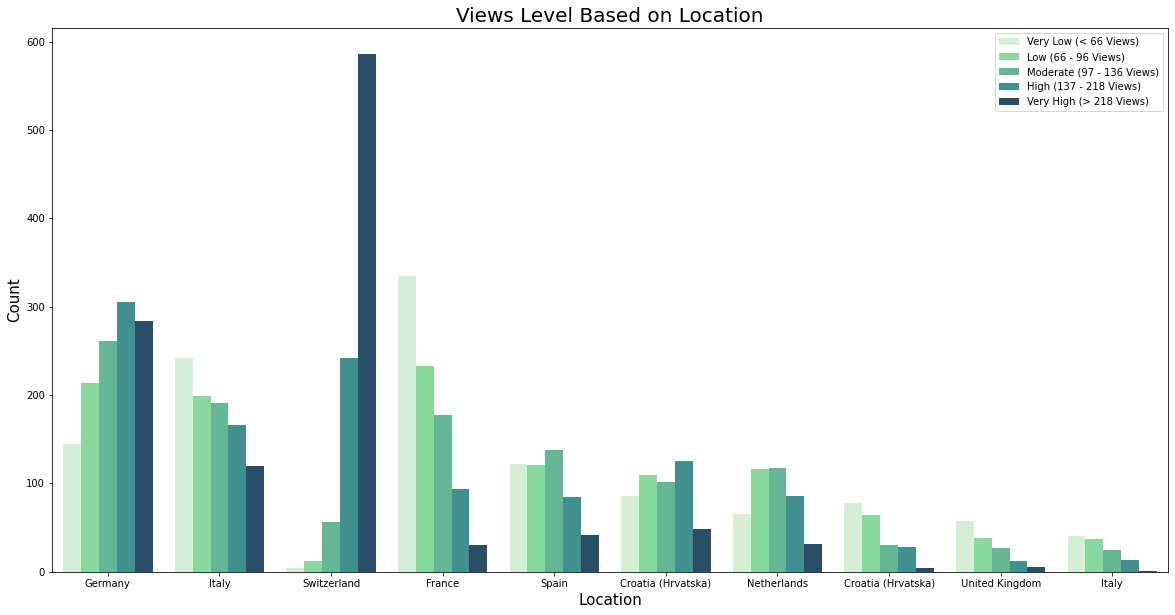

In [89]:
barplot('Location', 1, 'Views Level Based on Location', 100, 'Views Level')

And the last for the engine feature, even though Germany dominate the views in general but unleaded has the highest very high views bar

### Conclusion
Based on what we get from each feature visualization, we can conclude there are 6 common features among the most viewed boats.

1. Price. People tend to views the boat where its price is less than than 37 991€ 
2. When the boat is built. Since the old one has the cheaper price, people tend to choose the old boat, which in this data the boat that’s built in less 1999
3. Boat type. It's motor yacht, sport boat and cabin boat. Since these three dont really show many difference in their views page, we can choose one of these three.
4. Type. Used boat and unleaded is so popular among other type
5. Material. It’s clearly GRP
6. Location, the boat from Switzerland

So to help the marketing team increase their number of readers this year i recommend them to use this preference